# MovieLens negative sampling

In [72]:
figure_path = '/home/weiss/git/thesis/doc/figures/'

In [73]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

RANDOM = 2021

In [74]:
datasets = {
    'ml-100k': '/home/weiss/rs_data/ml-100k/',
}

dt='ml-100k'

In [75]:
# Check structure
def list_files(startpath):
    print(startpath)
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
dirs = [x[0] for x in os.walk(datasets[dt])]
ml = filter(lambda dirName: dirName if ('ml' in dirName) else '', list(dirs))
dt_dir_name= list(ml)[0]
print(list_files(dt_dir_name))

/home/weiss/rs_data/ml-100k/
/
    README
    u2.test
    u4.test
    u2.base
    allbut.pl
    u3.base
    u.data
    u.occupation
    ua.test
    u5.base
    u.genre
    u3.test
    ub.test
    mku.sh
    u.user
    u1.test
    ua.base
    u1.base
    u.item
    u5.test
    ub.base
    u4.base
    ml-100k.pkl
    u.info
processed/
    test.csv
    rX_val.csv
    rX_test_ns.csv
    rX_test.csv
    train.csv
    rX_train.csv
    rX_val_ns.csv
    test_ns.csv
    rX_train_ns.csv
    val.csv
    val_ns.csv
    train_ns.csv
None


In [76]:
# Select ratings and tags
if dt=='ml-100k':
  ratings_data = pd.read_csv(dt_dir_name +'/'+ 'u.data', delimiter='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
  user_data = pd.read_csv(dt_dir_name +'/'+ 'u.user', delimiter='|', names=['user id', 'age' ,'gender' ,'occupation' , 'zip code'])
  genres = ['unknown', 'Action' ,'Adventure' ,'Animation',
              'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy',
              'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi',
              'Thriller' ,'War' ,'Western']
  movie_data = pd.read_csv(dt_dir_name +'/'+ 'u.item', delimiter='|', names=['movie id' ,'movie title' ,'release date' ,'video release date' ,
              'IMDb URL'] + genres)
  genre_list =  pd.read_csv(dt_dir_name +'/'+ 'u.genre', delimiter='|', names=['user id', 'age' ,'gender' ,'occupation' , 'zip code'])
  print('ratings data', ratings_data.shape)
  print('user data', user_data.shape)
  print('movie data', movie_data.shape)

ratings data (100000, 4)
user data (943, 5)
movie data (1682, 24)


In [77]:
# Check ratings data
print(ratings_data.head())
print(ratings_data.info())
print('Ratings null?\n', ratings_data.isnull().any())

   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100000 non-null  int64
 1   movieId    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None
Ratings null?
 userId       False
movieId      False
rating       False
timestamp    False
dtype: bool


In [78]:
# Check user data
print(user_data.head())
print('Users null?\n', user_data.isnull().any())

   user id  age gender  occupation zip code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213
Users null?
 user id       False
age           False
gender        False
occupation    False
zip code      False
dtype: bool


In [79]:
# Check movie data
print(movie_data.head())
print('movie null?\n', movie_data.isnull().any())

   movie id        movie title release date  video release date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1         1  ...        0          0       0        0   


In [80]:
rating_count_by_user = ratings_data.groupby('userId').size().sort_values(ascending=False)
print(rating_count_by_user)

userId
405    737
655    685
13     636
450    540
276    518
      ... 
685     20
475     20
36      20
732     20
596     20
Length: 943, dtype: int64


In [81]:
gender_prop = user_data.groupby(['gender']).size().reset_index(name='count')
gender_prop['percent'] = gender_prop['count'] / gender_prop['count'].sum()
print(gender_prop)

  gender  count   percent
0      F    273  0.289502
1      M    670  0.710498


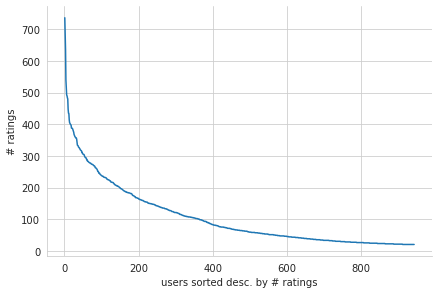

In [82]:
size = rating_count_by_user.size

df = pd.DataFrame(dict(sorted_user_id=range(1,size+1), rating_counts=rating_count_by_user.values))

image = sns.relplot(data=df,
                    x="sorted_user_id",
                    y="rating_counts",
                    kind="line",
                    height=4,
                    aspect=1.5
                    )

image.fig

image.set(xlabel="users sorted desc. by # ratings",
          ylabel="# ratings"
          )

image.savefig(figure_path + '/ml-100k-long-tail-distribution.png', dpi=300, bbox_inches='tight')

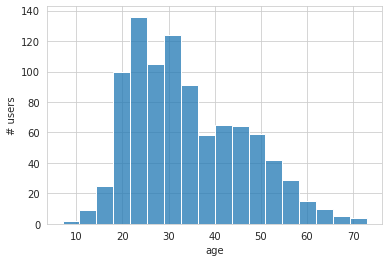

In [83]:

image = sns.histplot(data = user_data,
                     x = 'age')

image.set(ylabel="# users",
          #title="ML-100k long-tail distribution"
          )

image.figure.savefig(figure_path + 'ml-100k-user-age-hist.png', dpi=300, bbox_inches='tight')

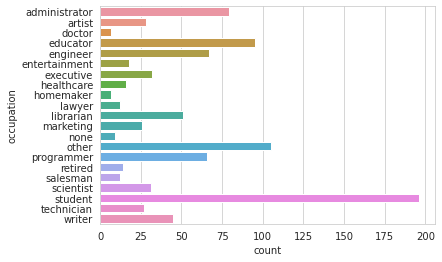

In [84]:
df = user_data.groupby(['occupation']).size().reset_index(name='count')

image = sns.barplot(data = df,
            y = 'occupation',
            x= 'count'
            )
image.figure.savefig(figure_path + 'ml-100k-user-occupation.png', dpi=300, bbox_inches='tight')

In [85]:
data = dict(genre=[], count=[])
for genre in genres:
    count = movie_data[genre].value_counts()[1]
    data['genre'].append(genre)
    data['count'].append(count)
genre_counts = pd.DataFrame(data)
print(genre_counts)

          genre  count
0       unknown      2
1        Action    251
2     Adventure    135
3     Animation     42
4      Children    122
5        Comedy    505
6         Crime    109
7   Documentary     50
8         Drama    725
9       Fantasy     22
10    Film-Noir     24
11       Horror     92
12      Musical     56
13      Mystery     61
14      Romance    247
15       Sci-Fi    101
16     Thriller    251
17          War     71
18      Western     27


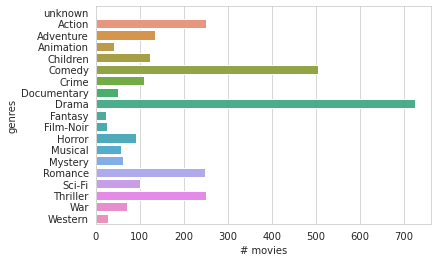

In [86]:
fig, image = plt.subplots()


image = sns.barplot(data = genre_counts,
            y = 'genre',
            x= 'count'
            )
image.set_xlabel('# movies')
image.set_ylabel('genres')

image.figure.savefig(figure_path + 'ml-100k-genre-counts.png', dpi=300, bbox_inches='tight')